# Trying to perform crossover and mutation in latent space of images and text

In [41]:
from model_helpers.auto_device import auto_device, auto_to_device
from diffusers.utils import make_image_grid
from diffusers import DiffusionPipeline
from pathlib import Path
from PIL import Image
import pandas as pd
import time
import csv
import torch

In [1]:
def setup_diffusion_pipeline(model_id, variant="fp16"):
    """
    Helper function to load a model from the HuggingFace model hub and return a pipeline.
    Tries to load the fp16 variant if available.
    """
    pipe = None
    try:
        pipe = DiffusionPipeline.from_pretrained(
            model_id, torch_dtype=torch.float16, variant=variant,
            use_safetensors=True, safety_checker=None, requires_safety_checker=False
        )
        pipe = auto_to_device(pipe)
        print(f"Loaded {pipe}")
    except Exception as e:
        print(f"Could not load {model_id}: {e}")

    return pipe

models = [
    "stabilityai/sd-turbo",
    "stabilityai/sdxl-turbo",
    "stabilityai/stable-diffusion-xl-base-1.0",
    "stabilityai/stable-diffusion-2-1",
    "prompthero/openjourney",
    "kandinsky-community/kandinsky-3"
]

In [25]:
pipeline = setup_diffusion_pipeline(models[1])

Keyword arguments {'safety_checker': None, 'requires_safety_checker': False} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}


In [24]:
from model_helpers.auto_device import auto_device
from diffusers import StableDiffusionPipeline

tokenizer = pipeline.tokenizer
tokenizer_2 = pipeline.tokenizer_2
text_encoder = pipeline.text_encoder
text_encoder_2 = pipeline.text_encoder_2

# Your prompt
prompt = "hello dog"
batch_size = 1
device = auto_device()
text_inputs = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

# Get the output from the text encoder
text_input_ids = text_inputs.input_ids
untruncated_ids = tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
    text_input_ids, untruncated_ids
):
    removed_text = tokenizer.batch_decode(untruncated_ids[:, tokenizer.model_max_length - 1 : -1])
    print(
        "The following part of your input was truncated because CLIP can only handle sequences up to"
        f" {tokenizer.model_max_length} tokens: {removed_text}"
    )

with torch.no_grad():
    prompt_embeds = text_encoder(text_input_ids.to(device), output_hidden_states=True)
    # We are only ALWAYS interested in the pooled output of the final text encoder
    pooled_prompt_embeds = prompt_embeds.pooler_output
    # "2" because SDXL always indexes from the penultimate layer.
    prompt_embeds = prompt_embeds.last_hidden_state

print(prompt_embeds.shape)
print(pooled_prompt_embeds.shape)

# Use the pipeline with custom embeddings
generated_image = pipeline(
    prompt_embeds=prompt_embeds,
    pooled_prompt_embeds=pooled_prompt_embeds,
    num_inference_steps=2,
    #batch_size=1, defined by prompt_embeds
    guidance_scale=0.0
).images[0]
generated_image

torch.Size([1, 77, 768])
torch.Size([1, 768])


  0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (1x2304 and 2816x1280)

In [88]:
def mutate_tensor(tensor, mutation_rate=0.05, mutation_strength=0.1, clamp_range=(-1, 1)):
    """
    Perform a mutation on the tensor while keeping it on the same device.

    Args:
    - tensor (torch.Tensor): The tensor to mutate.
    - mutation_rate (float): Fraction of elements to mutate (between 0 and 1).
    - mutation_strength (float): The strength of the mutation, influencing how much each element can change.
    - clamp_range (tuple): A tuple of (min, max) to clamp the mutated values.

    Returns:
    - torch.Tensor: The mutated tensor.
    """
    device = tensor.device  # Get the device of the input tensor
    num_elements_to_mutate = int(torch.numel(tensor) * mutation_rate)
    indices_to_mutate = torch.randperm(torch.numel(tensor), device=device)[:num_elements_to_mutate]

    # Generate mutations
    mutations = torch.randn(num_elements_to_mutate, device=device) * mutation_strength
    flat_tensor = tensor.flatten()
    flat_tensor[indices_to_mutate] += mutations
    mutated_tensor = flat_tensor.view(tensor.shape)

    # Clamp values to ensure they remain within a reasonable range
    mutated_tensor = torch.clamp(mutated_tensor, min=clamp_range[0], max=clamp_range[1])
    
    return mutated_tensor

def crossover_tensors(tensor1, tensor2, crossover_rate=0.5):
    """
    Perform a crossover operation between two tensors, assuming they are on the same device.

    Args:
    - tensor1 (torch.Tensor): The first parent tensor.
    - tensor2 (torch.Tensor): The second parent tensor.
    - crossover_rate (float): The rate at which elements from the second tensor are introduced into the first.

    Returns:
    - torch.Tensor: The resulting tensor after crossover.
    """
    if tensor1.shape != tensor2.shape:
        raise ValueError("Both tensors must have the same shape for crossover.")

    # Create a mask for crossover
    crossover_mask = torch.rand(tensor1.shape, device=tensor1.device) < crossover_rate

    # Perform crossover
    offspring = torch.where(crossover_mask, tensor2, tensor1)

    return offspring

def interpolate_tensors(tensor1, tensor2, interpolation_weight=0.5):
    """
    Perform an interpolation-based crossover between two tensors.

    Args:
    - tensor1 (torch.Tensor): The first parent tensor.
    - tensor2 (torch.Tensor): The second parent tensor.
    - interpolation_weight (float): The weight for interpolation (between 0 and 1). A weight of 0.5 results in an
      equal blend of both tensors.

    Returns:
    - torch.Tensor: The resulting tensor after interpolation.
    """
    if tensor1.shape != tensor2.shape:
        raise ValueError("Both tensors must have the same shape for interpolation.")

    # Ensure tensors are on the same device
    device = tensor1.device
    tensor2 = tensor2.to(device)

    # Perform interpolation
    offspring = tensor1 * (1 - interpolation_weight) + tensor2 * interpolation_weight

    return offspring

tensor([[-1.0576, -0.0349, -1.3662,  ..., -0.6309, -1.5547,  0.3655]],
       device='mps:0', dtype=torch.float16, grad_fn=<LinearBackward0>)
tensor([[-0.5386,  0.3643, -0.2791,  ..., -2.4219, -1.1250, -0.1322]],
       device='mps:0', dtype=torch.float16, grad_fn=<AddBackward0>)


  0%|          | 0/2 [00:00<?, ?it/s]

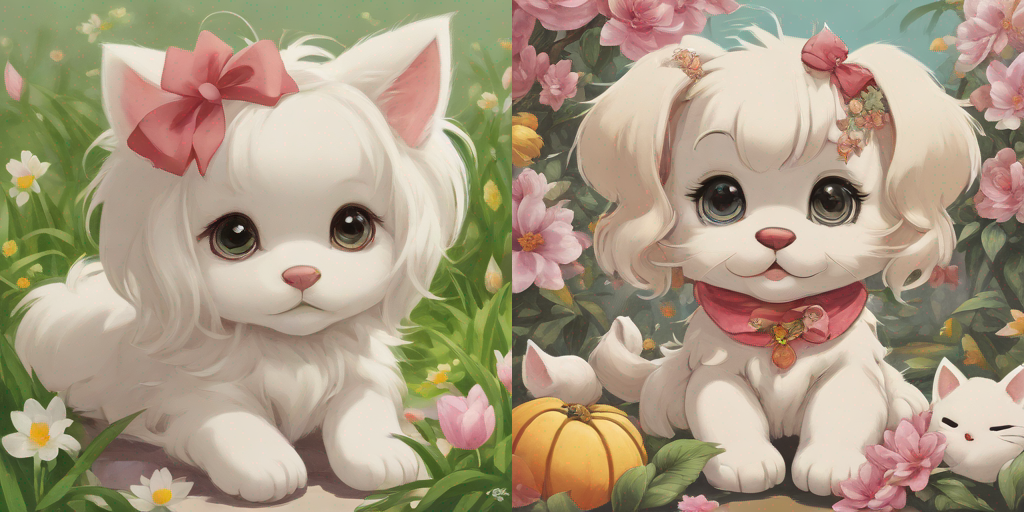

In [101]:
tokenizer = pipeline.tokenizer
tokenizer_2 = pipeline.tokenizer_2
text_encoder = pipeline.text_encoder
text_encoder_2 = pipeline.text_encoder_2

# Your prompt
prompt = "dog in the style of hello kitty anime 8k high quality amazing stunning art"
batch_size = 2
device = auto_device()

# From SDXL, this uses multiple text encoders and tokenizers
tokenizers = [tokenizer, tokenizer_2] if tokenizer is not None else [tokenizer_2]
text_encoders = (
    [text_encoder, text_encoder_2] if text_encoder is not None else [text_encoder_2]
)

prompt_2 = None
prompt_2 = prompt_2 or prompt
prompt_2 = [prompt_2] if isinstance(prompt_2, str) else prompt_2

# textual inversion: procecss multi-vector tokens if necessary
prompt_embeds_list = []
prompts = [prompt, prompt_2]
for prompt, tokenizer, text_encoder in zip(prompts, tokenizers, text_encoders):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_input_ids = text_inputs.input_ids
    untruncated_ids = tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

    if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
        text_input_ids, untruncated_ids
    ):
        removed_text = tokenizer.batch_decode(untruncated_ids[:, tokenizer.model_max_length - 1 : -1])
        print(
            "The following part of your input was truncated because CLIP can only handle sequences up to"
            f" {tokenizer.model_max_length} tokens: {removed_text}"
        )

    prompt_embeds = text_encoder(text_input_ids.to(device), output_hidden_states=True)

    # We are only ALWAYS interested in the pooled output of the final text encoder
    pooled_prompt_embeds = prompt_embeds[0]
    # "2" because SDXL always indexes from the penultimate layer.
    prompt_embeds = prompt_embeds.hidden_states[-2]
    prompt_embeds_list.append(prompt_embeds)
# end for
prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)

print(pooled_prompt_embeds)
prompt_embeds = interpolate_tensors(prompt_embeds, pp1)
pooled_prompt_embeds = interpolate_tensors(pooled_prompt_embeds, pp2)
#prompt_embeds = crossover_tensors(prompt_embeds, pp1)
#pooled_prompt_embeds = crossover_tensors(pooled_prompt_embeds, pp2)
#prompt_embeds = mutate_tensor(prompt_embeds, mutation_rate=0.1, mutation_strength=3, clamp_range=(-10, 10))
#pooled_prompt_embeds = mutate_tensor(pooled_prompt_embeds, mutation_rate=0.5, mutation_strength=3, clamp_range=(-10, 10))
print(pooled_prompt_embeds)


images = pipeline(
    prompt_embeds=prompt_embeds,
    pooled_prompt_embeds=pooled_prompt_embeds,
    num_inference_steps=2,
    num_images_per_prompt=batch_size, #defined by prompt_embeds
    guidance_scale=0.0
).images

make_image_grid(images, rows=1, cols=batch_size)

In [81]:
pp1 = prompt_embeds
pp2 = pooled_prompt_embeds